# Taylor-Hood elements for Stokes

This miniapp demonstrates a FEM implementation of the incompressible Stokes equations:


\begin{aligned}
\frac{\partial \mathbf{u}}{\partial t} - \nu \nabla^2 \mathbf{u} + \nabla p &= 0 \quad \text{in } \Omega, \\
\nabla \cdot \mathbf{u} &= 0 \quad \text{in } \Omega,
\end{aligned}


---

- Uses **Taylor–Hood elements** for mixed finite element formulation.
- **P2–P1** elements:
  - Velocity: Continuous piecewise **quadratic** functions ($\mathbb{P}_2$)
  - Pressure: Continuous piecewise **linear** functions ($\mathbb{P}_1$)

---

### Import Libraries (Only Numpy, Matlotlib and SciPy are allowed)

In [71]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri

from scipy.spatial import Delaunay
from scipy.sparse import bmat, csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata

### Functions relating to the mesh

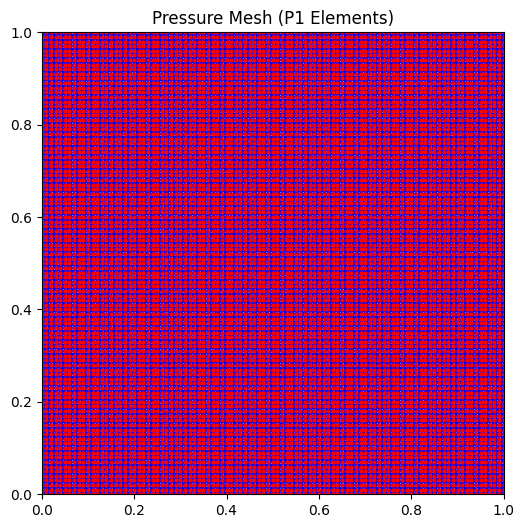

Mesh Summary:
 - Number of nodes: 10201
 - Number of triangles: 20000
 - Domain size: 1.00 x 1.00


In [72]:
def generate_triangular_mesh(x_len=1.0, y_len=1.0, mesh_size=0.1):
    num_x = int(x_len / mesh_size) + 1
    num_y = int(y_len / mesh_size) + 1
    x = np.linspace(0, x_len, num_x)
    y = np.linspace(0, y_len, num_y)
    X, Y = np.meshgrid(x, y)
    points = np.vstack([X.ravel(), Y.ravel()]).T
    triangulation = Delaunay(points)
    mesh = {
        'points': points,
        'triangles': triangulation.simplices,  # IEN
        'num_x': num_x,
        'num_y': num_y
    }
    return mesh


def plot_mesh(mesh, x_len=1.0, y_len=1.0):
    tri_obj = tri.Triangulation(mesh['points'][:, 0], mesh['points'][:, 1], mesh['triangles'])
    plt.figure(figsize=(6, 6))
    plt.triplot(tri_obj, color='blue')
    plt.plot(mesh['points'][:, 0], mesh['points'][:, 1], 'o', color='red', markersize=2)
    plt.xlim(0, x_len)
    plt.ylim(0, y_len)
    plt.gca().set_aspect('equal')
    plt.title("Pressure Mesh (P1 Elements)")
    plt.show()
    num_nodes = mesh['points'].shape[0]
    num_triangles = mesh['triangles'].shape[0]
    print("Mesh Summary:")
    print(" - Number of nodes:", num_nodes)
    print(" - Number of triangles:", num_triangles)
    print(" - Domain size: {:.2f} x {:.2f}".format(x_len, y_len))


# Create and plot the mesh
mesh = generate_triangular_mesh(mesh_size=0.01)
plot_mesh(mesh)


Quadratic mesh for velocity:
 - Number of velocity nodes (P2): 40401
 - Number of elements: 20000


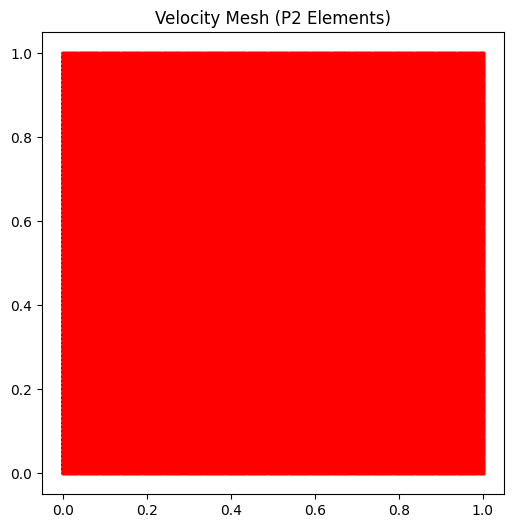

In [73]:

def generate_quadratic(V, E, return_edges=False):
    """
    Generate a quadratic element list by adding midpoints to each edge.
    Parameters:
      V : ndarray of shape (nv, 2) with vertex coordinates.
      E : ndarray of shape (ne, 3) with triangle connectivity.
      return_edges : bool, optional. If True, also return the list of edges.

    Returns:
      V2 : ndarray with original vertices and new mid–edge nodes.
      E2 : ndarray of shape (ne, 6) with connectivity: first three columns for vertices,
           next three columns for corresponding mid–edge nodes.
      (if return_edges==True, also returns Edges, an array of edge vertex indices)
    """
    if not isinstance(V, np.ndarray) or not isinstance(E, np.ndarray):
        raise ValueError('V and E must be ndarray')
    if V.shape[1] != 2 or E.shape[1] != 3:
        raise ValueError('V should be nv x 2 and E should be ne x 3')

    ne = E.shape[0]

    # Build a vertex-to-vertex graph (each triangle gives 3 edges)
    ID = np.kron(np.arange(0, ne), np.ones((3,), dtype=int))
    from scipy.sparse import coo_matrix, tril
    G = coo_matrix((np.ones((ne * 3,), dtype=int), (E.ravel(), ID)))
    V2V = G * G.T

    # Get lower-triangular part (unique edges)
    V2Vmid = tril(V2V, -1)
    Edges = np.vstack((V2Vmid.row, V2Vmid.col)).T
    # Compute midpoints for these edges
    Vmid = (V[Edges[:, 0], :] + V[Edges[:, 1], :]) / 2.0
    V2 = np.vstack((V, Vmid))
    # Map each edge (i, j) to the new node number (at the end of V)
    maxindex = E.max() + 1
    newID = maxindex + np.arange(Edges.shape[0])
    V2Vmid.data = newID
    V2Vmid = V2Vmid + V2Vmid.T

    # Extend element connectivity: new columns for mid–edge nodes (edges: 0–1, 1–2, 2–0)
    E2 = np.hstack((E, np.zeros((ne, 3), dtype=int)))
    # Force conversion to 1D arrays so that each entry is a scalar integer.
    E2[:, 3] = np.array(V2Vmid[E[:, 0], E[:, 1]]).flatten()
    E2[:, 4] = np.array(V2Vmid[E[:, 1], E[:, 2]]).flatten()
    E2[:, 5] = np.array(V2Vmid[E[:, 2], E[:, 0]]).flatten()

    if return_edges:
        return V2, E2, Edges
    return V2, E2

# Generate quadratic mesh (for velocity)
V2, E2 = generate_quadratic(mesh['points'], mesh['triangles'])
print("Quadratic mesh for velocity:")
print(" - Number of velocity nodes (P2):", V2.shape[0])
print(" - Number of elements:", E2.shape[0])

# For illustration, we plot the quadratic mesh (only the original vertices in the triangle connectivity)
plt.figure(figsize=(6, 6))
tri_obj = tri.Triangulation(V2[:, 0], V2[:, 1], E2[:, :3])
plt.triplot(tri_obj, color='blue')
plt.plot(V2[:, 0], V2[:, 1], 'o', color='red', markersize=2)
plt.title("Velocity Mesh (P2 Elements)")
plt.gca().set_aspect('equal')
plt.show()


In [74]:

def assemble_stokes_system(mesh, V2, E2, nu=1.0):
    """
    Assemble the finite element matrices for the steady Stokes equations
    using Taylor–Hood elements.

    Inputs:
       mesh : dict with keys 'points' and 'triangles' (P1 mesh for pressure)
       V2   : ndarray (N_vel, 2) for velocity nodes (P2 mesh)
       E2   : ndarray (ne, 6) connectivity for quadratic elements (first three entries correspond to the P1 vertices)
       nu   : viscosity

    Returns:
       S : Global saddle–point system matrix in CSR format.
       rhs : Right–hand side vector.
       dof_info : dictionary of degrees of freedom indices for velocity and pressure.
                  'vel' indices range for velocity (each with 2 components) and
                  'pres' for pressure (P1 nodes).
    """
    # Number of degrees of freedom
    N_pres = mesh['points'].shape[0]  # pressure dofs (original mesh vertices)
    N_vel = V2.shape[0]  # velocity dofs (each node has two components)
    ndof_vel = 2 * N_vel
    ndof = ndof_vel + N_pres

    # Prepare lists for COO entries for the blocks A and B.
    rows_A = []
    cols_A = []
    vals_A = []

    rows_B = []  # for the coupling matrix B (pressure vs. velocity)
    cols_B = []
    vals_B = []

    # For the force vector, assume f = 0 for simplicity.
    f_global = np.zeros(ndof_vel)
    # Pressure right-hand side is also zero.
    g_global = np.zeros(N_pres)

    # Quadrature rule for triangles (6–point rule)
    quad_pts = np.array([
        [-0.10810301816807008, -0.78379396366385990],
        [-0.10810301816806966, -0.10810301816807061],
        [-0.78379396366386020, -0.10810301816806944],
        [-0.81684757298045740, -0.81684757298045920],
        [0.63369514596091700, -0.81684757298045810],
        [-0.81684757298045870, 0.63369514596091750]
    ])
    quad_w = np.array([
        0.44676317935602256,
        0.44676317935602256,
        0.44676317935602256,
        0.21990348731064327,
        0.21990348731064327,
        0.21990348731064327
    ])
    # Map quadrature points from [-1,1] to [0,1] (affine map for the reference triangle)
    xi_q = (quad_pts[:, 0] + 1) / 2
    eta_q = (quad_pts[:, 1] + 1) / 2
    w_q = quad_w * 0.5  # adjust weights

    ne = E2.shape[0]
    for ei in range(ne):
        # Velocity element connectivity: 6 nodes (indices into V2)
        vel_nodes = E2[ei, :]  # shape (6,)
        # Pressure element connectivity: first 3 vertices (indices into mesh['points'])
        pres_nodes = E2[ei, :3]

        # Geometry: use the three pressure nodes for affine mapping.
        vertices = mesh['points'][pres_nodes, :]  # shape (3, 2)
        x0, y0 = vertices[0, :]
        x1, y1 = vertices[1, :]
        x2, y2 = vertices[2, :]
        J = np.array([[x1 - x0, x2 - x0],
                      [y1 - y0, y2 - y0]])
        detJ = np.linalg.det(J)
        if detJ <= 0:
            raise ValueError("Non–positive Jacobian determinant encountered.")
        invJ = np.linalg.inv(J)

        # Local matrices initialization.
        A_loc = np.zeros((12, 12))  # 6 nodes * 2 velocity components
        B_loc = np.zeros((3, 12))  # 3 pressure nodes x 12 velocity dofs

        # Loop over quadrature points.
        for (xi, eta, w) in zip(xi_q, eta_q, w_q):
            # Quadratic velocity basis functions (P2) on the reference triangle.
            N_basis = np.array([
                (1 - xi - eta) * (1 - 2 * xi - 2 * eta),  # N1
                xi * (2 * xi - 1),                        # N2
                eta * (2 * eta - 1),                      # N3
                4 * xi * (1 - xi - eta),                  # N4
                4 * xi * eta,                             # N5
                4 * eta * (1 - xi - eta)                  # N6
            ])
            # Derivatives with respect to xi and eta.
            dN_dxi = np.array([
                -3 + 4 * xi + 4 * eta,
                4 * xi - 1,
                0,
                4 - 8 * xi - 4 * eta,
                4 * eta,
                -4 * eta
            ])
            dN_deta = np.array([
                -3 + 4 * xi + 4 * eta,
                0,
                4 * eta - 1,
                -4 * xi,
                4 * xi,
                4 - 4 * xi - 8 * eta
            ])
            # Transform derivatives to physical coordinates.
            grad_N = np.zeros((6, 2))
            for i in range(6):
                dN_ref = np.array([dN_dxi[i], dN_deta[i]])
                grad_N[i, :] = invJ.T @ dN_ref

            # Linear pressure basis functions (P1, barycentrics) and their constant gradients.
            phi = np.array([1 - xi - eta, xi, eta])
            dphi_ref = np.array([[-1, -1],
                                 [1, 0],
                                 [0, 1]])
            grad_phi = (invJ.T @ dphi_ref.T).T  # shape (3, 2)

            weight = w * detJ
            # Assemble local velocity matrix.
            for i in range(6):
                for j in range(6):
                    grad_dot = np.dot(grad_N[i], grad_N[j])
                    A_loc[i, j] += nu * grad_dot * weight  # u-u block
                    A_loc[i + 6, j + 6] += nu * grad_dot * weight  # v-v block
            # Assemble coupling (divergence) matrix.
            for a in range(3):
                for j in range(6):
                    B_loc[a, j] += - phi[a] * grad_N[j, 0] * weight  # u-component
                    B_loc[a, j + 6] += - phi[a] * grad_N[j, 1] * weight  # v-component

        # Global assembly for velocity.
        for local_i in range(12):
            # Skip near-zero diagonal entries for efficiency.
            if abs(A_loc[local_i, local_i]) < 1e-14:
                continue
            if local_i < 6:
                gi = vel_nodes[local_i]  # u-component index
            else:
                gi = vel_nodes[local_i - 6] + N_vel  # v-component index (N_vel is the total number of velocity nodes)
            for local_j in range(12):
                if local_j < 6:
                    gj = vel_nodes[local_j]
                else:
                    gj = vel_nodes[local_j - 6] + N_vel
                rows_A.append(gi)
                cols_A.append(gj)
                vals_A.append(A_loc[local_i, local_j])

        # Global assembly for coupling matrix B.
        for a in range(3):
            gi_p = pres_nodes[a]  # pressure dof (in original mesh)
            # Global pressure index is shifted after velocity dofs.
            for local_j in range(12):
                if local_j < 6:
                    gj = vel_nodes[local_j]
                else:
                    gj = vel_nodes[local_j - 6] + N_vel
                rows_B.append(gi_p)
                cols_B.append(gj)
                vals_B.append(B_loc[a, local_j])

    # Build the global velocity stiffness matrix.
    A_global = csr_matrix((vals_A, (rows_A, cols_A)), shape=(ndof_vel, ndof_vel))
    # Build the coupling matrix B (size: N_pres x ndof_vel).
    B = csr_matrix((vals_B, (np.array(rows_B), np.array(cols_B))), shape=(N_pres, ndof_vel))

    # Create the full saddle–point system matrix.
    zero_pp = csr_matrix((N_pres, N_pres))
    S = bmat([[A_global, -B.transpose()],
              [B, zero_pp]], format='csr')

    # Assemble the global right–hand side.
    rhs = np.concatenate([f_global, g_global])

    dof_info = {'vel': np.arange(ndof_vel), 'pres': np.arange(ndof_vel, ndof)}
    return S, rhs, dof_info


# Example usage:
print("Assembling system...")
S, rhs, dof_info = assemble_stokes_system(mesh, V2, E2, nu=1.0)
print("Global system size:", S.shape)


Assembling system...
Global system size: (91003, 91003)


In [75]:
# For the velocity we impose homogeneous Dirichlet conditions (u=0) on the boundary,
# and for pressure we fix one degree of freedom (p=0) for uniqueness.

def apply_boundary_conditions(S, rhs, mesh, V2, dof_info, vel_tol=1e-6):
    ndof = S.shape[0]
    S = S.tolil()  # convert to LIL for modification

    N_vel = V2.shape[0]
    # Identify velocity nodes on the boundary (unit square).
    boundary_vel_nodes = []
    for i, (x, y) in enumerate(V2):
        if (abs(x - 0) < vel_tol or abs(x - 1) < vel_tol or
                abs(y - 0) < vel_tol or abs(y - 1) < vel_tol):
            boundary_vel_nodes.append(i)
    boundary_dofs = []
    for node in boundary_vel_nodes:
        boundary_dofs.append(node)  # u-component
        boundary_dofs.append(node + N_vel)  # v-component

    # Enforce u = 1 on the top lid
    for dof in boundary_dofs:
       # Check if the node is on the top boundary (y = 1)
       node_index = dof % N_vel  # Get the node index
       if abs(V2[node_index, 1] - 1) < vel_tol:
           if dof < N_vel:  # u-component
               S[dof, :] = 0
               S[dof, dof] = 1.0
               rhs[dof] = 1.0  # Set u = 1
           else:
               S[dof, :] = 0
               S[dof, dof] = 1.0
               rhs[dof] = 0.0  # Set v = 0 (as before)
       else:
           # Other boundaries (u = 0, v = 0)
           S[dof, :] = 0
           S[dof, dof] = 1.0
           rhs[dof] = 0.0

    # Remove the Null space, so fix a pressure point to 0
    p_fix = dof_info['pres'][0]
    S[p_fix, :] = 0
    S[p_fix, p_fix] = 1.0
    rhs[p_fix] = 0.0

    return S.tocsr(), rhs


S_bc, rhs_bc = apply_boundary_conditions(S, rhs, mesh, V2, dof_info)
print("Applied boundary conditions.")


Applied boundary conditions.


In [76]:
print("Solving the linear system...")
sol = spsolve(S_bc, rhs_bc)
print("Solution computed.")

N_vel = V2.shape[0]
u = sol[:N_vel]
v = sol[N_vel:2 * N_vel]
p = sol[2 * N_vel:]

Solving the linear system...
Solution computed.


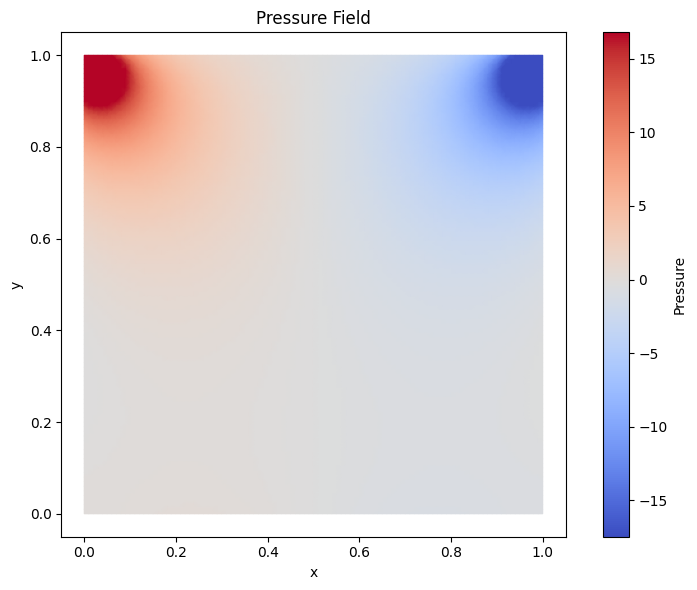

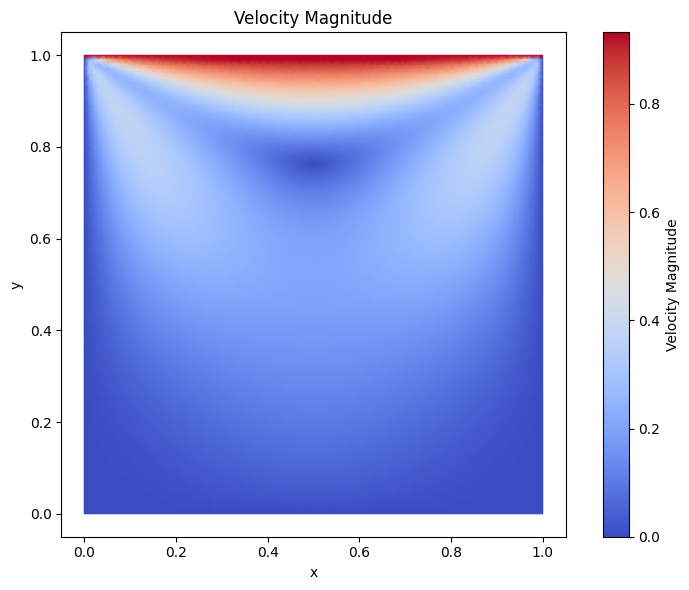

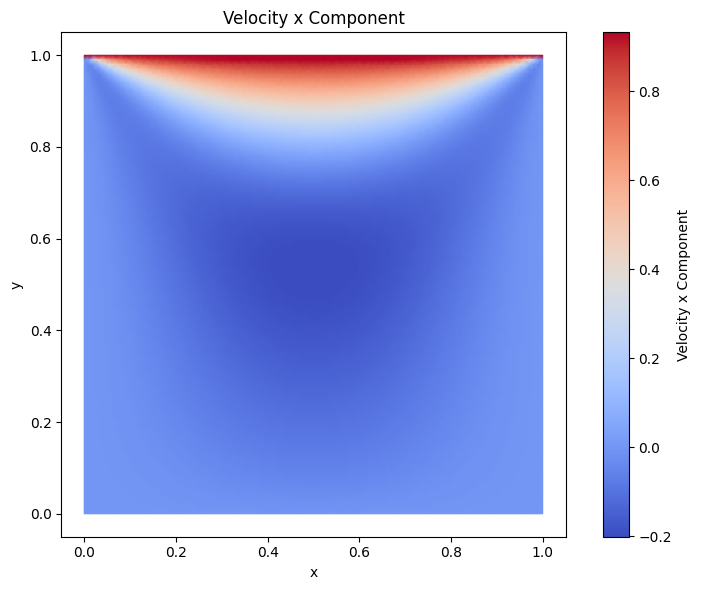

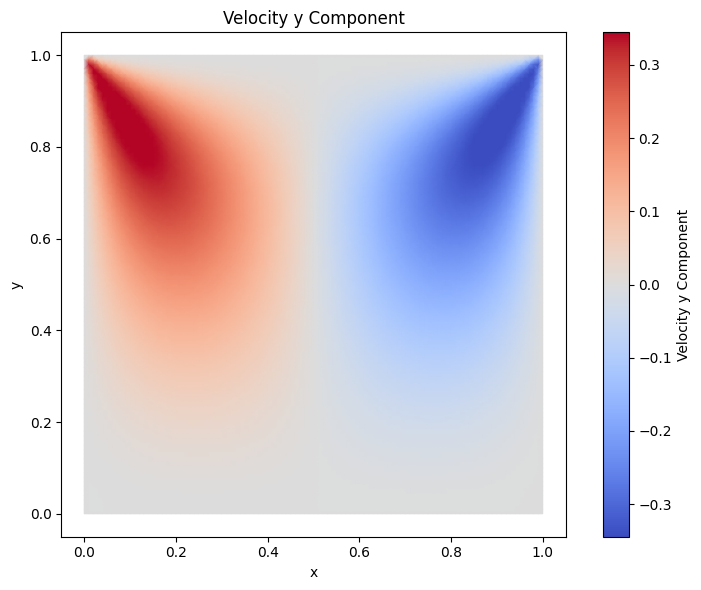

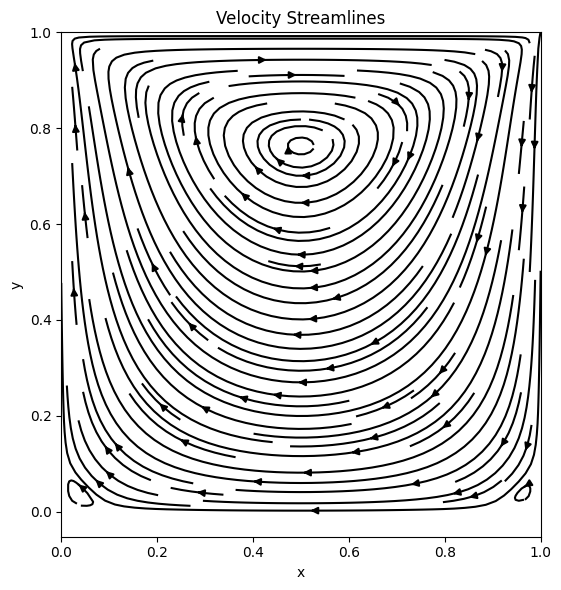

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

def plot_pressure(mesh, p):
    """
    Plot the pressure field using a diverging colormap suitable for flow fields.
    The colormap is set to "coolwarm" with percentile-based clipping (1st and 99th percentiles)
    to reduce the influence of extreme outliers.
    """
    pmin, pmax = np.percentile(p, [1, 99])

    plt.figure(figsize=(8, 6))
    tri_obj = tri.Triangulation(mesh['points'][:, 0],
                                mesh['points'][:, 1],
                                mesh['triangles'])

    # Use a diverging colormap ("coolwarm") and clip the data at the 1st and 99th percentiles.
    tpc = plt.tripcolor(tri_obj, p, shading='gouraud', cmap='coolwarm',
                        vmin=pmin, vmax=pmax)

    plt.colorbar(tpc, label='Pressure')
    plt.title("Pressure Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()


def plot_velocity(V2, u, v):
    U = u
    Vv = v
    vel_mag = np.sqrt(U**2 + Vv**2)

    # Create a triangulation object from the velocity node coordinates and connectivity.
    tri_obj = tri.Triangulation(V2[:, 0], V2[:, 1], E2[:, :3])

    # ---- Plot Velocity Magnitude ----
    plt.figure(figsize=(8, 6))
    mag_min, mag_max = np.percentile(vel_mag, [1, 99])
    tpc = plt.tripcolor(tri_obj, vel_mag, shading='gouraud', cmap='coolwarm',
                        vmin=mag_min, vmax=mag_max)
    plt.colorbar(tpc, label='Velocity Magnitude')
    plt.title("Velocity Magnitude")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # ---- Plot Velocity x Component ----
    plt.figure(figsize=(8, 6))
    ux_min, ux_max = np.percentile(U, [1, 99])
    tpc_x = plt.tripcolor(tri_obj, U, shading='gouraud', cmap='coolwarm',
                          vmin=ux_min, vmax=ux_max)
    plt.colorbar(tpc_x, label='Velocity x Component')
    plt.title("Velocity x Component")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # ---- Plot Velocity y Component ----
    plt.figure(figsize=(8, 6))
    vy_min, vy_max = np.percentile(Vv, [1, 99])
    tpc_y = plt.tripcolor(tri_obj, Vv, shading='gouraud', cmap='coolwarm',
                          vmin=vy_min, vmax=vy_max)
    plt.colorbar(tpc_y, label='Velocity y Component')
    plt.title("Velocity y Component")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # ---- Streamline Plot ----
    # Determine the interpolation grid boundaries from V2.
    x_min, x_max = np.min(V2[:, 0]), np.max(V2[:, 0])
    y_min, y_max = np.min(V2[:, 1]), np.max(V2[:, 1])

    # Determine the number of grid points from unique coordinates, with a fallback value.
    unique_x = np.unique(V2[:, 0])
    unique_y = np.unique(V2[:, 1])
    num_x = len(unique_x) if len(unique_x) > 1 else 50
    num_y = len(unique_y) if len(unique_y) > 1 else 50

    xi = np.linspace(x_min, x_max, num_x)
    yi = np.linspace(y_min, y_max, num_y)
    Xg, Yg = np.meshgrid(xi, yi)

    Ug = griddata(V2, U, (Xg, Yg), method='linear')
    Vg = griddata(V2, Vv, (Xg, Yg), method='linear')

    plt.figure(figsize=(8, 6))
    plt.streamplot(xi, yi, Ug, Vg, density=1.5, color='k')
    plt.title("Velocity Streamlines")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()


plot_pressure(mesh, p)
plot_velocity(V2, u, v)
